* 참조 깃헙
    * 모델 하나로 만들자.
* Base code
    * https://github.com/GunhoChoi/PyTorch-FastCampus/blob/master/07_Transfer_Learning/0_Pretrained_Basic/Transfer_Learning.ipyn
        * 모델 하나로 만들자.
    * 01_pretrainedVGG_media_v4
    * MediaClassifier_a_VGG
* MediaClassifier_d_Densenet

## 1. Settings
### 1) Important required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

### 2) Hyperparameter

In [2]:
batch_size= 8  #1
learning_rate = 0.0001
epoch = 70

n_node = 32  # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.3   # 얼마나 드랍시킬지 inverse keepratio 

imgsize = 256

## 2. Data Loader
### 1) Training data
### (Option1) Only real artwork from Web crawling

In [3]:
# 1. Train data
img_dir = "../../../images/painting_dataset/real_artwork_divided_shffl_4K/Train"
#img_dir = "../images/car_dataset2/car_training"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(imgsize*2),     # ① CenterCrop(512)
            transforms.RandomCrop(imgsize),       # ③ RandomCrop
            transforms.RandomHorizontalFlip(),    # ② RandomHorizontalFlip
    
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
train_batch = data.DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

/home/user/anaconda2/lib/python2.7/site-packages/torchvision-0.2.0-py2.7.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


### (Option2) Option1 + Textbook artwork

In [4]:
# img_dir = "../../images/painting_dataset/real_artwork_divided_shffl_4K/Train"
# #img_dir = "../images/car_dataset2/car_training"
# #img_dir = "../../images/painting_dataset/real_artwork_textbook_div/Train"

# train_data1 = dset.ImageFolder(img_dir, transforms.Compose([    
#             transforms.CenterCrop(imgsize*2),     # ① CenterCrop(512)
#             transforms.RandomCrop(imgsize),       # ③ RandomCrop
#             transforms.RandomHorizontalFlip(),    # ② RandomHorizontalFlip
    
#             transforms.Scale(imgsize),
#             transforms.ToTensor()
#             ]))
# print(train_data1.__len__())
 
    
# #img_dir = "../../images/painting_dataset/real_artwork_textbook_refinement"
# img_dir = "../../images/painting_dataset/real_artwork_textbook/real_artwork_textbook_refinement_small0.5_div/Train"
# train_data2 = dset.ImageFolder(img_dir, transforms.Compose([
#             # ①(512)③②RCrop  <-- Best !!
#             transforms.CenterCrop(imgsize*2),     # ① CenterCrop(512)
#             transforms.RandomCrop(imgsize),       # ③ RandomCrop
#             transforms.RandomHorizontalFlip(),    # ② RandomHorizontalFlip
    
# #             transforms.CenterCrop(imgsize),    
# #             transforms.RandomHorizontalFlip(),    
    
#             transforms.Scale(imgsize),
#             transforms.ToTensor()
#             ]))
# print(train_data2.__len__())

# #train_data = train_data1  
# train_data = list(train_data1) + list(train_data2)
# train_batch = data.DataLoader(train_data, batch_size=batch_size,
#                             shuffle=True, num_workers=2)

### 2) Development (validation), Test data

In [16]:
# 2. Dev data
img_dir = "../../../images/painting_dataset/real_artwork_divided_shffl_4K/Valid"
#img_dir = "../../images/painting_dataset/real_artwork_textbook_div/Valid"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)

# 3. Test data
img_dir = "../../../images/painting_dataset/real_artwork_divided_shffl_4K/Test"
#img_dir = "../../images/painting_dataset/real_artwork_textbook_div/Test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
test_batch = data.DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)
        
nclass = len(dev_data.classes)
print("# of classes: %d" %nclass)
print(dev_data.classes)
print(dev_data.class_to_idx)
print(dev_data.__len__())

print("Training: %d, Dev: %d, Test: %d, " %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# for imgs, labels in train_batch:
#     for j in range(len(imgs)):
#         img = transforms.ToPILImage()(imgs[j])
#         plt.title("label: %d" % labels[j])
#         plt.imshow(img)
#         plt.show()

# 4. Synthesized data
#img_dir = "../../../images/painting_dataset/synthesized_evenCategory-no_paper_folder"
img_dir = "../../../images/painting_dataset/synthesized/synthesized_papers_total/synthesized_papers_total_rf05_no_paper_folder"
synth_data = dset.ImageFolder(img_dir, transforms.Compose([    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
synth_batch = data.DataLoader(synth_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)
print("Synth: %d, " %synth_data.__len__()),

# 5. Textbook refinement data
#img_dir = "../../images/painting_dataset/real_artwork_textbook/real_artwork_textbook_refinement"
img_dir = "../../../images/painting_dataset/real_artwork_textbook/real_artwork_textbook_refinement_small0.5_div/Test"
textbook_data = dset.ImageFolder(img_dir, transforms.Compose([    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
textbook_batch = data.DataLoader(textbook_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)
print("Textbook: %d" %textbook_data.__len__())

# of classes: 4
['oil', 'pastel', 'pencil', 'water']
{'water': 3, 'pastel': 1, 'oil': 0, 'pencil': 2}
620
Training: 2895, Dev: 620, Test: 621,  Synth: 421,  Textbook: 70


## 3. Model
### 1) Pretrained Densenet Model

In [6]:
densenet = models.densenet161(pretrained=True)

for name,module in densenet.named_children():
    print(name)

# print(list(vgg.children())[0])
# print(list(vgg.children())[-1])

# print("\n")

#cnt = 0
for i in densenet.children():
    #print("yhk[%d]" %cnt),
    print(i)
    #cnt = cnt+1

features
classifier
Sequential(
  (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  (relu0): ReLU(inplace)
  (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
      (relu.1): ReLU(inplace)
      (conv.1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
      (relu.2): ReLU(inplace)
      (conv.2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm.1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True)
      (relu.1): ReLU(inplace)
      (conv.1): Conv2d(144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm.2): BatchNorm2d(

### 2) Customized Fully Model

In [7]:
fsize = imgsize/32  # 8  # layer1 의 avgPool 직전 wid, hei

class MyDensenet(nn.Module):
    def __init__(self):
        super(MyDensenet, self).__init__()
        self.layer0 = nn.Sequential(*list(densenet.children())[0])  # [0]: features(conv), [1]: classifier(fc)
        self.layer1 = nn.Sequential(
            #nn.Linear(8*base_dim * fsize * fsize, 1024),
            nn.Linear(2208*8*8, n_node),   # 256*6*6: out = self.layer0(x) 의 out 을 프린트하는 무식한 방법으로 알아냄.
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),  # 0.3 만큼 drop 하자.
            
#             nn.Linear(n_node, n_node),
#             nn.BatchNorm1d(n_node),
#             nn.ReLU(),
#             nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        # weight initialization
        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)  # REUL 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x):
        out = self.layer0(x)
        #print(out)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

### 3) Model on GPU

In [8]:
model = MyDensenet().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True

In [9]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
      (relu.1): ReLU(inplace)
      (conv.1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
      (relu.2): ReLU(inplace)
      (conv.2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm.1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True)
      (relu.1): ReLU(inplace)
      (conv.1): Conv2d(144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
   

## 4. Optimizer & Loss

In [10]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate)

## 5. Train

In [11]:
import utils

total_time = 0
disp_step = 10

to_train = False
if (to_train==False):
    netname = './nets/media_dense_RCrop_fixed.pkl'   # with data augmentation ①(512)③②RCrop
    #netname = './nets/media_dense_textbook_fixed.pkl'
    #netname = './nets/media_dense_fixed.pkl'  # without data augmentation
    #netname = './nets/media_dense_RSCRC_fixed.pkl'   # with data augmentation ①(512)④②RSCrop
    model = torch.load(netname)
else:    
    model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    synth_corr = utils.ComputeCorr(synth_batch, model)
    textbook_corr = utils.ComputeCorr(textbook_batch, model)
    print("1 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    print("Correct of train: %.2f, dev: %.2f, test: %.2f, synth: %.2f, textbook: %.2f" 
          %(train_corr, dev_corr, test_corr, synth_corr, textbook_corr))
    model.train()
    
    netname = './nets/media_dense.pkl'

    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습을 재시작한다면
#     netname = '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad = False    
#     for params in model.layer1.parameters():
#         params.required_grad = True
#     for i in range(34, epoch):
    
    # 재시작하지 않는 다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()

            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output,label)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i==epoch-1):
            torch.save(model, netname, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            # train, dev, train accr
            model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            synth_corr = utils.ComputeCorr(synth_batch, model)
            textbook_corr = utils.ComputeCorr(textbook_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, synth: %.2f, textbook: %.2f" 
                  %(train_corr, dev_corr, test_corr, synth_corr, textbook_corr)),
            model.train()            
            print("time: %.2f sec.." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

/home/user/anaconda2/lib/python2.7/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/user/anaconda2/lib/python2.7/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/user/anaconda2/lib/python2.7/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing t

In [ ]:
# epoch-err curve 
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6. Evaluation for dev & test data

In [ ]:
model.eval()   # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


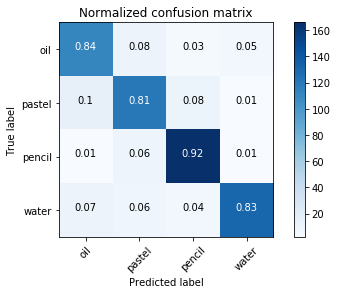

Confusion matrix, without normalization


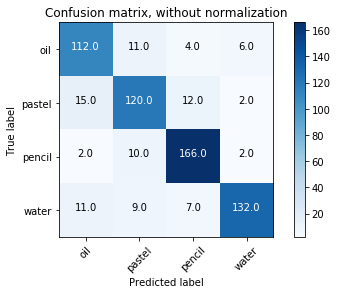

	 acc  |	 pre  |	 rec  |	 f1
 oil: 0.92 |	 0.80 |	 0.84 |	 0.82
 pastel: 0.87 |	 0.80 |	 0.81 |	 0.80
 pencil: 0.90 |	 0.88 |	 0.92 |	 0.90
 water: 0.94 |	 0.93 |	 0.83 |	 0.88
*accuracy: 0.91, precision: 0.85, recall: 0.85, *f1 score: 0.85
[AP] oil: 0.92 pastel: 0.87 pencil: 0.96 water: 0.94 
[mAP] 0.924
[miAP] 0.950


(array([0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 2,
        0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3,
        0, 3, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [12]:
model.eval()
utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Normalized confusion matrix


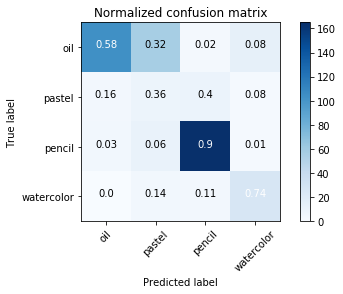

Confusion matrix, without normalization


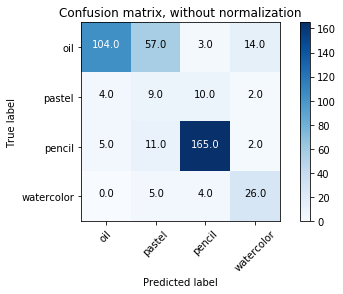

	 acc  |	 pre  |	 rec  |	 f1
 oil: 0.80 |	 0.92 |	 0.58 |	 0.71
 pastel: 0.74 |	 0.11 |	 0.36 |	 0.17
 pencil: 0.87 |	 0.91 |	 0.90 |	 0.90
 watercolor: 0.94 |	 0.59 |	 0.74 |	 0.66
*accuracy: 0.84, precision: 0.63, recall: 0.65, *f1 score: 0.61
[AP] oil: 0.93 pastel: 0.18 pencil: 0.98 watercolor: 0.73 
[mAP] 0.704
[miAP] 0.903


(array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0,
        3, 2, 2, 3, 3, 1, 1, 0, 0, 1, 0, 1, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        3, 1, 3, 3, 3, 1, 0, 0, 1, 2, 1, 3, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 3, 2, 1, 3, 0, 2, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2,
        1, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 

In [17]:
model.eval()
utils.EvaluateClassifier(synth_batch, model, synth_data.classes, batch_size)

In [ ]:
model.eval()
utils.EvaluateClassifier(textbook_batch, model, textbook_data.classes, batch_size)

## 7. Visualize true & false predicted images

In [ ]:
model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.VisTFPred(dev_batch, model, dev_data.classes, batch_size, 2)

In [ ]:
model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.VisTFPred(test_batch, model, test_data.classes, batch_size, 30)

In [ ]:
model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.VisTFPred(synth_batch, model, synth_data.classes, batch_size, 2)

In [ ]:
model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.VisTFPred(textbook_batch, model, textbook_data.classes, batch_size, 2)

## 8. Evaluate by basic & voting
* voting 시 주의: 반드시 random 하게 크롭할 것! center crop 만 하면 voting 하기 전과 정확히 같은 방법
    * 예) 
    * transforms.CenterCrop(imgsize*2),    
    * transforms.RandomCrop(imgsize),      

### 1) Test data (basic & voting)

In [ ]:
img_dir = "../../images/painting_dataset/real_artwork_divided_shffl_4K/Test"
utils.EvalData(img_dir, model, None, batch_size)
utils.EvalData(img_dir, model, "WSum", batch_size, 5)  # weighted sum (직접선거)
utils.EvalData(img_dir, model, "WVot", batch_size, 5)  # voting (가중치 간접선거)
utils.EvalData(img_dir, model, "Vot", batch_size, 5)

### 2) Synthesized data (basic & voting)

In [ ]:
img_dir = "../../images/painting_dataset/synthesized_evenCategory-no_paper_folder"
utils.EvalData(img_dir, model, None, batch_size)
utils.EvalData(img_dir, model, "WSum", batch_size, 5)  # weighted sum (직접선거)

### 3) Textbook data (basic & voting)

In [ ]:
img_dir = "../../images/painting_dataset/real_artwork_textbook/real_artwork_textbook_refinement_small0.5_div/Test"
utils.EvalData(img_dir, model, None, batch_size)
utils.EvalData(img_dir, model, "WSum", batch_size, 5)  # weighted sum (직접선거)

## 9. Human test data (basic & voting)
* Human 설문에 사용된 data 의 원본 데이터로 성능 측정하자

In [ ]:
img_dir = "../../images/painting_dataset/HumanTest/2_Human2NetOrig/1) RealArtwork" 
utils.EvalData(img_dir, model, None, batch_size)
utils.EvalData(img_dir, model, "WSum", batch_size, 5)  # weighted sum (직접선거)

In [ ]:
img_dir = "../../images/painting_dataset/HumanTest/2_Human2NetOrig/3) Synthesized" 
utils.EvalData(img_dir, model, None, batch_size)
utils.EvalData(img_dir, model, "WSum", batch_size, 5)  # weighted sum (직접선거)

In [ ]:
img_dir = "../../images/painting_dataset/HumanTest/2_Human2NetOrig/2) Textbook" 
utils.EvalData(img_dir, model, None, batch_size)
utils.EvalData(img_dir, model, "WSum", batch_size, 5)  # weighted sum (직접선거)

### Visualize true & false predicted images

In [ ]:
img_dir = "../../images/painting_dataset/HumanTest/2_Human2NetOrig/1) RealArtwork" 
my_data = dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
my_batch = data.DataLoader(my_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)

model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.VisTFPred(my_batch, model, my_data.classes, batch_size, 3)

## 10. Evaluate paper results 

In [ ]:
# import utils

# img_dir = "../../images/painting_dataset/synthesized/synthesized_papers_total/synthesized_papers_total_rf02" 
# utils.EvalPaper(img_dir, model, False, batch_size)
# #utils.EvalPaper(img_dir, model, True, batch_size, 5)

In [ ]:
# # ========================================================================
# # '논문' Data 에 대해 basic or (weighted) voting 방식 평가 해주기
# # ========================================================================
# # * EvalData() 와 비슷
# # * EvaluateClassifier(Vot) 함수 사용함
# # * 굳이 image directory 를 넣은이유? voting 은 transform 이 달라요. 랜덤 크롭해야해서
# # * img_dir: text할 이미지 경로
# # * Mode: 평가방식. {None, "WSum", "WVot", "Vot"}
# def EvalPaper(i_img_dir, i_model, Mode=None, 
#               i_batch_size=32, i_n_vot=2, i_imgsize=256, 
#               is_show_img=False):
#     i_model.eval()
#     if (Mode==None):
#         # 0. 데이터 로드
#         my_data = dset.ImageFolder(i_img_dir, transforms.Compose([        
#                 transforms.CenterCrop(size=i_imgsize),
            
#                 transforms.Scale(i_imgsize),
#                 transforms.ToTensor()
#                 ]))
#         batch = data.DataLoader(my_data, batch_size=i_batch_size,
#                                     shuffle=False, num_workers=2)
#         print("data len: %d" %my_data.__len__())
#         print("--- [Data] %s ---" %i_img_dir)
#         print("--- [평가방식] Basic ---")
        
#         # 1. 평가
#         pred, label, prob = utils.EvaluateClassifier(batch, i_model, my_data.classes, i_batch_size)
        
#         # 2. 논문 별 결과 그래프 그리기
#         utils.VisPaper(i_img_dir, my_data.classes, pred, label, prob)
#     else:
#         # 0. 데이터 로드
#         my_data = dset.ImageFolder(i_img_dir, transforms.Compose([    
#                     transforms.CenterCrop(i_imgsize*2),  
#                     transforms.RandomCrop(i_imgsize),  

#                     transforms.Scale(i_imgsize),
#                     transforms.ToTensor()
#                     ]))
#         batch = data.DataLoader(my_data, batch_size=i_batch_size,
#                                     shuffle=False, num_workers=2)
#         print("data len: %d" %my_data.__len__())
#         print("--- [Data] %s ---" %i_img_dir)
        
#         if (Mode=="WSum"):
#             print("--- [평가방식] Weighted sum (직접선거) ---")
#             # 1. 평가
#             pred, label, prob = utils.EvaluateClassifierWeightedSum(batch, i_model, my_data.classes, i_n_vot, i_batch_size) 
#         elif (Mode=="WVot"):
#             print("--- [평가방식] Weighted voting (가중치 간접선거) ---")
#             pred, label, prob = EvaluateClassifierVot(batch, i_model, my_data.classes, i_n_vot, i_batch_size, True)
#         elif (Mode=="Vot"):
#             print("--- [평가방식] Voting (간접선거) ---")
#             pred, label, prob = EvaluateClassifierVot(batch, i_model, my_data.classes, i_n_vot, i_batch_size, False)
#         else:
#             print("Wrong Mode input.")
#             print("The Mode must be only one of {None, \"WSum\", \"WVot\", \"Vot\"}")
#             return
        
#         # 2. 논문 별 결과 그래프 그리기
#         utils.VisPaper(i_img_dir, my_data.classes, pred, label, prob)
        
#     # 3. is_show_img
#     if (is_show_img):
#         cnt = 0
#         for imgs, labels in batch:
#             for i in range(len(imgs)):
#                 img = transforms.ToPILImage()(imgs[i])
#                 #plt.title("true: %s, pred: %s" %(my_data.classes[label[cnt]], my_data.classes[pred[cnt]]))
#                 curr_y = label[cnt]
#                 curr_pred = pred[cnt]
#                 curr_prob = prob[cnt]
#                 plt.title("Pred: %d(%s) %.2f / True: %d(%s)" %(curr_pred, my_data.classes[curr_pred], curr_prob*100.0,
#                                                                curr_y, my_data.classes[curr_y]))
#                 plt.imshow(img)
#                 plt.show()
#                 cnt = cnt + 1

#### Avg. of probability for each paper
$ avg.(prob) = 1/N \Sigma_i^N I_i p_i $
.
$ I_i=1 (true predicted)
I_i=-1 (false predicted)$

In [ ]:
# oil 초점
img_dir = "../../images/painting_dataset/synthesized/synthesized_papers_total/synthesized_papers_total_rf02" 
# utils.EvalPaper(img_dir, model, None, batch_size, is_show_img=False)
# utils.EvalPaper(img_dir, model, "WSum", batch_size, 5, is_show_img=True)
utils.EvalPaper(img_dir, model, "WVot", batch_size, 5, is_show_img=False)
utils.EvalPaper(img_dir, model, "Vot", batch_size, 5, is_show_img=False)

In [ ]:
# 해상도 512로 줄임
img_dir = "../../images/painting_dataset/synthesized/synthesized_papers_total/synthesized_papers_total_rf03" 
utils.EvalPaper(img_dir, model, None, batch_size, is_show_img=False)
utils.EvalPaper(img_dir, model, "WSum", batch_size, 5, is_show_img=False)

In [ ]:
img_dir = "../../images/painting_dataset/synthesized/synthesized_papers_total/synthesized_papers_total_rf02"
my_data = dset.ImageFolder(img_dir, transforms.Compose([        
    transforms.CenterCrop(size=imgsize),
    transforms.Scale(imgsize),
    transforms.ToTensor()
    ]))
my_batch = data.DataLoader(my_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)

pred, _, _= utils.ComputePred(my_batch, model, batch_size)